Estimate impulse responses to word onset and surprisal in the Brennan 2018 dataset, controlling (hopefully eventually) for word acoustics.

In [1]:
import logging
logging.basicConfig(level=logging.DEBUG, handlers=[])
from pathlib import Path
import re

from matplotlib import pyplot as plt
import mne
mne.set_log_level(logging.WARNING)
from mne.decoding import ReceptiveField
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.signal
import scipy.stats
from tqdm.notebook import tqdm

basedir = Path("..").resolve()
import sys
sys.path.append(str(basedir))

DATA_DIR = Path("/om/data/public/language-eeg/brennan2018-v2")

FILTER_WINDOW = (0.5, 20)
RF_WINDOW = (-0.1, 0.7)

# TODO: What is right for this montage?
# N400_ELECTRODES = ["1", "14", "24", "25", "26", "29", "30", "31", "41", "42", "44", "45"]
# Picking some central anterior sensors here
N400_ELECTRODES = ["45", "34", "35", "1"]

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-4cgs3x9a because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from mfn400.adapters.brennan2018 import BrennanDatasetAdapter

In [42]:
data = BrennanDatasetAdapter(DATA_DIR)

loading subject data:   0%|          | 0/33 [00:00<?, ?it/s]

2022-06-09 16:52:14 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 1
2022-06-09 16:52:14 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 1
2022-06-09 16:52:16 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 3
2022-06-09 16:52:16 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 3
2022-06-09 16:52:19 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 4
2022-06-09 16:52:19 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 4
2022-06-09 16:52:21 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 5
2022-06-09 16:52:21 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 5
2022-06-09 16:52:23 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 6
2022-06-09 16:52:23 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 6
2022-06-09 16:52:26 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 8
2022-06-09 16:52:26 | DEBUG    | mfn400.adapters.brennan2018 | Loading subject 8
2022-06-09 16:52:28 | DEBUG 

In [43]:
data.run_preprocessing(filter_window=FILTER_WINDOW)

preprocessing subjects:   0%|          | 0/33 [00:00<?, ?it/s]

2022-06-09 16:53:28 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 1
2022-06-09 16:53:28 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 1
2022-06-09 16:53:29 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 3
2022-06-09 16:53:29 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 3
2022-06-09 16:53:30 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 4
2022-06-09 16:53:30 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 4
2022-06-09 16:53:31 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 5
2022-06-09 16:53:31 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 5
2022-06-09 16:53:32 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 6
2022-06-09 16:53:32 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 6
2022-06-09 16:53:33 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 8
2022-06-09 16:53:33 | DEBUG    | mfn400.ada

/net/vast-storage.ib.cluster/scratch/vast/cpl/jgauthie/scratch/broderick2018/mfn400/adapters/brennan2018.py:130: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw = raw.interpolate_bads()


2022-06-09 16:53:41 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 17
2022-06-09 16:53:41 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 17
2022-06-09 16:53:42 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 18
2022-06-09 16:53:42 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 18
2022-06-09 16:53:43 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 19
2022-06-09 16:53:43 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 19
2022-06-09 16:53:44 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 20
2022-06-09 16:53:44 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 20
2022-06-09 16:53:45 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 21
2022-06-09 16:53:45 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 21
2022-06-09 16:53:46 | DEBUG    | mfn400.adapters.brennan2018 | Preprocessing subject 22
2022-06-09 16:53:46 | DEBUG    |

In [44]:
data.get_presentation_data(1)

Word       onset      offset  Order  \
segment_idx sentence_idx word_idx                                             
1           1            1             Alice    3.772000    4.334721      1   
                         2               was    4.288721    4.556543      2   
                         3         beginning    4.510543    5.028929      3   
                         4                to    4.982929    5.124925      4   
                         5               get    5.078925    5.388327      5   
...                                      ...         ...         ...    ...   
12          84           6           happens  726.102879  726.548974   2146   
                         7              when  726.554450  726.767879   2147   
                         8               one  726.773355  726.935498   2148   
                         9              eats  726.940974  727.198899   2149   
                         10             cake  727.204375  727.558083   2150   

                                   LogFreq      SndPower    Length  IsLexical  \
segment_idx sentence_idx word_idx                                               
1           1            1            8.65  3.621500e-07  0.562721        1.0   
                         2           14.56  3.843500e-09  0.267822        0.0   
                         3           10.69  3.686500e-09  0.518386        1.0   
                         4           16.35  3.969700e-09  0.141996        0.0   
                         5           13.79  3.774700e-09  0.309402        0.0   
...                                    ...           ...       ...        ...   
12          84           6           10.77  7.081200e-04  0.446095        1.0   
                         7           13.76  3.221100e-03  0.213429        0.0   
                         8           14.17  1.984200e-03  0.162143        1.0   
                         9            8.15  2.473000e-05  0.257925        1.0   
                         10           8.74  5.423800e-06  0.353708        1.0   

                                      NGRAM       RNN       CFG  segment_onset  
segment_idx sentence_idx word_idx                                               
1           1            1         3.226499  3.126175  2.312348       3.726000  
                         2         0.905229  1.691128  1.357460       3.726000  
                         3         4.446766  4.100771  5.626722       3.726000  
                         4         2.537495  3.833313  5.939201       3.726000  
                         5         1.023137  1.013076  2.697304       3.726000  
...                                     ...       ...       ...            ...  
12          84           6         5.574428  6.356812  2.969568     680.876526  
                         7         4.059164  6.720639  4.930669     680.876526  
                         8         1.380381  2.187682  0.725398     680.876526  
                         9         3.171368  3.941021  2.767965     680.876526  
                         10        5.386008  5.832085  3.692958     680.876526  

[2129 rows x 12 columns]

In [55]:
# HACK: merge in control features computed from Alice repo.
# if this ends up working, we definitely need to merge in that code and clean this up.
extra_predictors = np.load(DATA_DIR / "predictors.npz")
def process_key(key_str):
    match = re.findall(r"^(\d+)/(.+)$", key_str)[0]
    return (int(match[0]), match[1])
extra_predictors = {process_key(key): value
                    for key, value in extra_predictors.items()}

# DISCLAIMER: This function is copied from https://github.com/nwhitehead/swmixer/blob/master/swmixer.py, 
#             which was released under LGPL. 
def resample_by_interpolation(signal, input_fs, output_fs):

    scale = output_fs / input_fs
    # calculate new length of sample
    n = round(len(signal) * scale)

    # use linear interpolation
    # endpoint keyword means than linspace doesn't go all the way to 1.0
    # If it did, there are some off-by-one errors
    # e.g. scale=2.0, [1,2,3] should go to [1,1.5,2,2.5,3,3]
    # but with endpoint=True, we get [1,1.4,1.8,2.2,2.6,3]
    # Both are OK, but since resampling will often involve
    # exact ratios (i.e. for 44100 to 22050 or vice versa)
    # using endpoint=False gets less noise in the resampled sound
    resampled_signal = np.interp(
        np.linspace(0.0, 1.0, n, endpoint=False),  # where to interpret
        np.linspace(0.0, 1.0, len(signal), endpoint=False),  # known positions
        signal,  # known data points
    )
    return resampled_signal


def resample_predictor(predictor_arr, target_sfreq, npad=100):
    times, xs = predictor_arr[:, 0], predictor_arr[:, 1:]
    input_sfreq = 1 / (times[1] - times[0])
    
    # TODO is this correct?
    new_times = np.linspace(times.min(), times.max(), num=int(np.ceil((times.max() - times.min()) * target_sfreq)),
                            endpoint=False)
    new_xs = [resample_by_interpolation(xs[:, i], input_sfreq, target_sfreq)
              for i in range(xs.shape[1])]
    
    return np.stack([new_times] + new_xs, axis=1)

extra_predictors = pd.concat({p: pd.DataFrame(v, columns=["time"] + [f"v{i}" for i in range(v.shape[1] - 1)]).melt(id_vars="time")
                              for p, v in extra_predictors.items()},
                             names=["segment", "feature"]).reset_index()

In [82]:
def prepare_control_predictors(dataset, subject_id):
    # Merge in segment onset data for subject.
    segment_onsets = dataset.get_presentation_data(subject_id).groupby("segment_idx").segment_onset.min()
    
    ret = extra_predictors.copy()
    ret["time"] += ret.segment.map(segment_onsets)
    
    # Drop control predictors for which there is no annotation data.
    # This is the case for some subjects with missing presentation / EEG data.
    ret = ret.dropna()
    
    sfreq = dataset._raw_data[subject_id].info["sfreq"]
    ret["sample"] = (ret.time * sfreq).astype(int)
    ret["feature"] = ret.feature.str.cat(ret.variable, sep="-")
    # resample within frequency bins
    ret = ret.groupby(["segment", "feature", "sample"]).value.mean().reset_index()
    
    return ret.pivot(["segment", "sample"], "feature", "value").reset_index()


def estimate_trf_coefs(dataset, subject_id):
    raw = dataset._raw_data[subject_id]
    Y, _ = raw["eeg"][:]
    
    p_df = data.get_presentation_data(subject_id)
    p_df["sample_idx"] = np.floor(p_df.onset * raw.info["sfreq"]).astype(int)
    
    # Prepare predictors.
    features = ["word_onset", "lexical_onset", "word_surprisal", "word_logfreq", "sound_power"]
    stim_seq = np.zeros((len(features), Y.shape[1]))
    stim_seq[0, p_df.sample_idx] = 1
    stim_seq[1:, p_df.sample_idx] = \
        p_df[["IsLexical", "RNN", "LogFreq", "SndPower"]].T.fillna(0.)
    
    control_features_df = prepare_control_predictors(dataset, subject_id)
    control_features = list(set(control_features_df.columns) - {"segment", "sample"})
    control_stim_seq = np.zeros((len(control_features), Y.shape[1]))
    control_stim_seq[:, control_features_df["sample"]] = control_features_df[control_features].T
    
    features = features + control_features
    stim_seq = np.concatenate([stim_seq, control_stim_seq], axis=0)
    
    # TODO CV
    rf = ReceptiveField(*RF_WINDOW, sfreq=raw.info["sfreq"],
                    feature_names=features,
                    estimator=1.,
                    scoring="corrcoef")
    rf.fit(stim_seq.T, Y.T)
    
    rf_ch_names = np.array(raw.ch_names)[mne.io.pick.pick_types(raw.info, eeg=True)].tolist()

    df = pd.concat([pd.DataFrame(feature_trf, index=rf_ch_names).rename_axis(index="sensor", columns="trf_sample").unstack()
                    for feature_trf in rf.coef_.transpose((1, 0, 2))],
                   keys=rf.feature_names, names=["feature", "trf_sample", "sensor"])
    df = pd.DataFrame(df, columns=["coef"])
    df["subject_id"] = subject_id
    
    return df

In [83]:
def estimate_all_trf_coefs(dataset):
    subject_ids = tqdm(dataset._raw_data.keys())
    df = pd.concat([estimate_trf_coefs(dataset, subject_id) for subject_id in subject_ids])
    return df

In [85]:
df = estimate_all_trf_coefs(data)

  0%|          | 0/33 [00:00<?, ?it/s]

In [86]:
df

coef  subject_id
feature        trf_sample sensor                          
word_onset     0          1       6.517899e-07           1
                          2      -2.207197e-07           1
                          3       9.485195e-07           1
                          4       1.493866e-06           1
                          5       1.493393e-06           1
...                                        ...         ...
gammatone-8-v4 400        58      1.056079e-08          48
                          59      1.144101e-08          48
                          60      1.149684e-08          48
                          61      2.042859e-08          48
                          29      6.604071e-09          48

[11300982 rows x 2 columns]

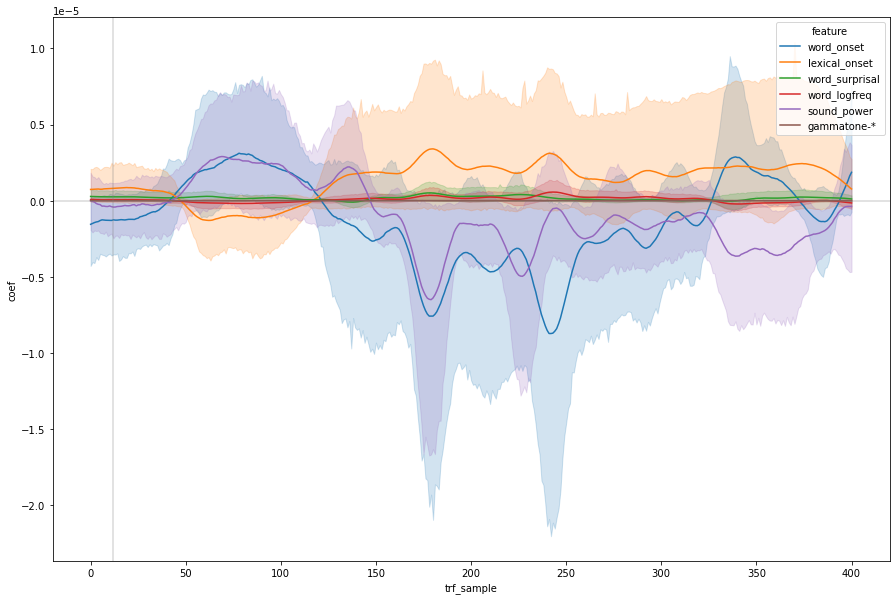

In [102]:
plt.subplots(figsize=(15, 10))

to_plot = df.xs("2", level="sensor").reset_index().copy()
to_plot["feature"] = to_plot.feature.str.replace(r"gammatone-.*", "gammatone-*", regex=True)
ax = sns.lineplot(data=to_plot,
                  x="trf_sample", y="coef", hue="feature")

ax.axhline(0, c="gray", alpha=0.3)
t0_sample = int((0 - RF_WINDOW[0]) * 128)
ax.axvline(t0_sample, c="gray", alpha=0.3)

In [99]:
df["abs_coef"] = df.coef.abs()
df.xs("word_surprisal", level='feature').groupby(["sensor", "trf_sample"]).abs_coef.median() \
    .groupby("sensor").max().sort_values(ascending=False)

sensor
60    1.975188e-07
8     1.906027e-07
22    1.866720e-07
59    1.844132e-07
23    1.795546e-07
          ...     
28    7.289585e-08
27    6.914907e-08
26    6.209745e-08
25    5.891675e-08
29    4.787024e-08
Name: abs_coef, Length: 61, dtype: float64

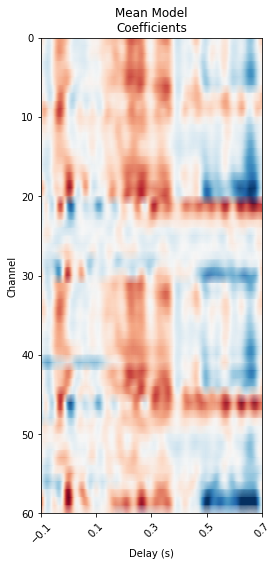

In [57]:
# TODO CV
# get coefficients for 0th feature across all sensors.
# shape: n_sensors * n_trf_samples
mean_coefs = rf.coef_[:, 0, :]
times = rf.delays_ / float(rf.sfreq)
ix_chs = np.arange(mean_coefs.shape[0])

fig, ax = plt.subplots(figsize=(4, 8))
max_coef = mean_coefs.max()
ax.pcolormesh(times, ix_chs, mean_coefs, cmap='RdBu_r',
              vmin=-max_coef, vmax=max_coef, shading='gouraud')
tmin, tmax = RF_WINDOW
ax.set(xlabel='Delay (s)', ylabel='Channel', title="Mean Model\nCoefficients",
       xlim=times[[0, -1]], ylim=[len(ix_chs) - 1, 0],
       xticks=np.arange(tmin, tmax + .2, .2))
plt.setp(ax.get_xticklabels(), rotation=45)
mne.viz.tight_layout()

In [53]:
mean_coefs.shape

(61, 401)